In [1]:
#import packages

import pandas as pd
import twint
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from string import punctuation
import re
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import textblob
from textblob import TextBlob
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline
from nltk.tokenize import sent_tokenize, word_tokenize

In [122]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\jacks\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

## Get Tweet Data

Before we start to analyize the data, we need a collection of tweets. So let's use Twint to scrape Twitter for all tweets that mention Billie Eilish. She will be our pilot subject that we'll use to gather data on so that we can start getting insights on her audience. Let's gather all tweets from the last year with 'billie eilish' as our search keyword.

In [2]:
#need a function to scrape twitter data


# c = twint.Config()


# c.Format = "ID {id} | Tweet {tweet}"
# c.Search = 'billie eilish'
# c.Lang = 'en'
# c.Pandas_clean = True
# c.Since = '2019-03-31'
# c.Store_csv = True
# c.Output = 'tweets.csv'
# twint.run.Search(c)



## Data Cleaning

In [2]:
#lets read in the dataframe

df = pd.read_csv('tweets.csv')


In [3]:
#how many tweets did we get?

df.shape

(14556, 34)

In [4]:
#let's see if there's anything missing from our dataframe and see if we can get rid of anything

df.isna().sum()

id                     0
conversation_id        0
created_at             0
date                   0
time                   0
timezone               0
user_id                0
username               0
name                   0
place              14554
tweet                  0
mentions               0
urls                   0
photos                 0
replies_count          0
retweets_count         0
likes_count            0
hashtags               0
cashtags               0
link                   0
retweet                0
quote_url          13731
video                  0
near               14556
geo                14556
source             14556
user_rt_id         14556
user_rt            14556
retweet_id         14556
reply_to               0
retweet_date       14556
translate          14556
trans_src          14556
trans_dest         14556
dtype: int64

In [5]:
df.drop(['place', 'quote_url', 'near', 'geo', 'source', 'user_rt_id', 'user_rt', 'retweet_id', 'retweet_date', 'translate', 
        'trans_src', 'trans_dest'], inplace=True, axis=1)

### Preprocess Raw Text



In [7]:
df['clean_tweets'] = df['tweet'].apply(lambda x: remove_links(x))

NameError: name 'remove_links' is not defined

In [8]:
#remove numbers and stopwrds from tweets
def preprocess(raw_text):

    # keep only words
    letters_only_text = re.sub("[^a-zA-Z]", " ", raw_text)
    
    #remove urls from tweets

    result1 = re.sub(r"http\S+", "", letters_only_text)
    result2 = re.sub(r"pic.twitter\S+", "", result1)
    result3 = re.sub(r"https\S+", "", result2)

    # convert to lower case and split 
    words = result3.lower().split()
    

    # remove stopwords
    stopword_set = set(stopwords.words("english"))
    meaningful_words = [w for w in words if w not in stopword_set]

    # join the cleaned words in a list
    cleaned_word_list = " ".join(word.lower() for word in meaningful_words)
   
    result = re.sub(r"billieeilish", "billie eilish", cleaned_word_list)

    return result

In [9]:
df['clean_tweets'] = df['tweet'].apply(lambda x: preprocess(x))

In [10]:
#create another column where the words are lemmatized

lemmatizer = WordNetLemmatizer()

In [11]:
df['lemmatized_tweets'] = df['clean_tweets'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

### Save Cleaned data

In [12]:
clean_df = df.to_csv('clean_billie_tweets.csv')

## EDA

### Open clean dataframe

In [13]:
clean_df = pd.read_csv('clean_billie_tweets.csv', index_col=0)


In [24]:
#let's explore the distribution of tweets by date

tweets_by_date = clean_df.groupby('date')['tweet'].count().reset_index()

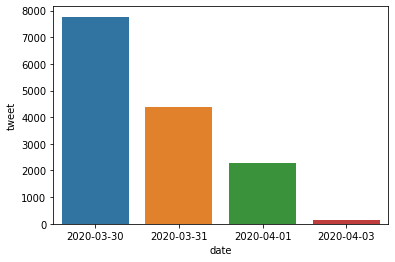

In [25]:
sns.barplot(data=tweets_by_date, x='date', y='tweet')

### Frequent Words

In [14]:
#let's visualize the most frequent words from the entire dataset

all_words = ' '.join([text for text in clean_df['clean_tweets'] if type(text) != float])


In [15]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)


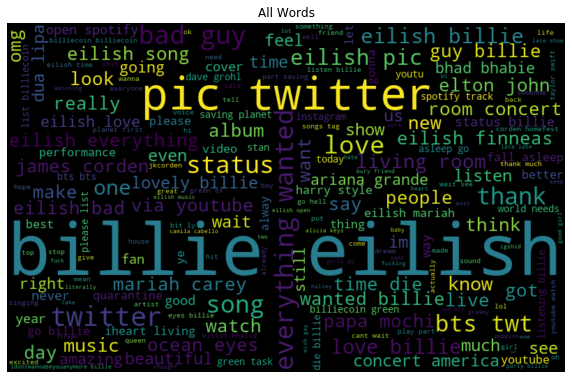

In [16]:
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('All Words')
plt.show()

In [17]:
#lets look out wordclouds for each date

march30_df = clean_df[clean_df['date'] == '2020-03-30']
march31_df = clean_df[clean_df['date'] == '2020-03-31']
april1_df = clean_df[clean_df['date'] == '2020-04-01']

m30_words = ' '.join([text for text in march30_df['clean_tweets'] if type(text) != float])
m30_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(m30_words)


m31_words = ' '.join([text for text in march31_df['clean_tweets'] if type(text) != float])
m31_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(m31_words)


a1_words = ' '.join([text for text in april1_df['clean_tweets'] if type(text) != float])
a1_wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(a1_words)


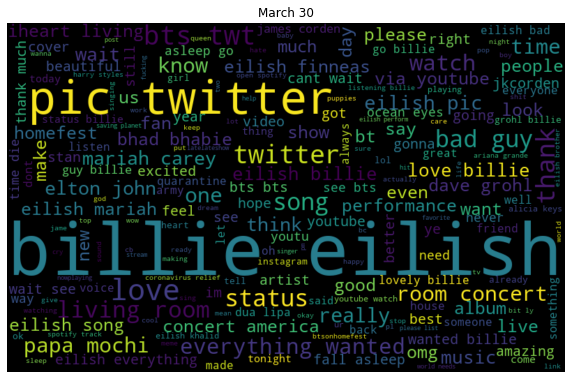

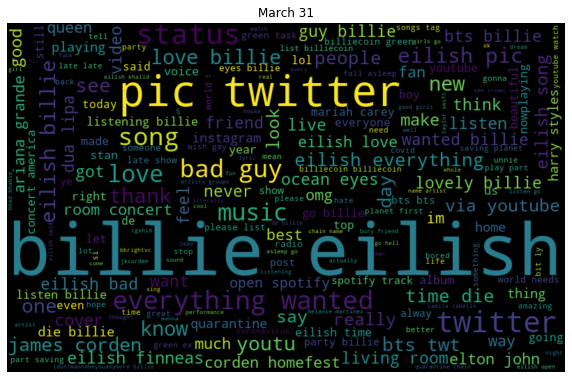

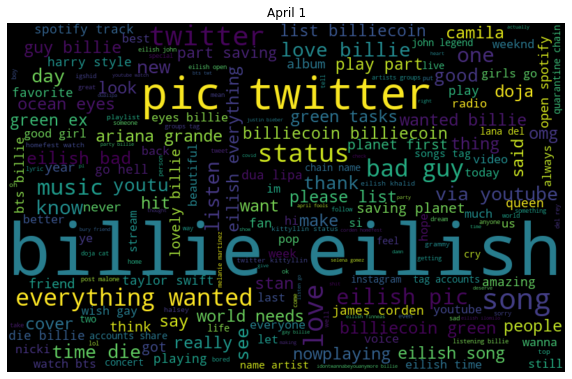

In [18]:


plt.figure(figsize=(10, 7))
plt.imshow(m30_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('March 30')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(m31_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('March 31')
plt.show()

plt.figure(figsize=(10, 7))
plt.imshow(a1_wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('April 1')
plt.show()

### TF-IDF
Let's calculate the importance of each word using TF-IDF scores. This will help us decide if there are other words we should be adding to our stopword list. Using non lemmatized words.

In [19]:
#drop rows with nan values in tweets
clean_df.dropna(axis=0, subset=['clean_tweets'], inplace=True)

#### Vectorize Words

In [20]:
#create function to vectorize song

def count_vectorize(tweet, vocab=None):
    tokenized_tweet = word_tokenize(tweet)
    if vocab:
        unique_words = vocab
    else:
        unique_words = list(set(tokenized_tweet))
    
    tweet_dict = {i:0 for i in unique_words}
    
    for word in tokenized_tweet:
        tweet_dict[word] += 1
    
    return tweet_dict

In [21]:
BoW = count_vectorize(clean_df['clean_tweets'][0])

In [135]:
#Term Frequency

#create term frequency function
def term_frequency(BoW_dict):
    total_word_count = sum(BoW_dict.values())
    
    for ind, val in BoW_dict.items():
        BoW_dict[ind] = val/ total_word_count
    
    return BoW_dict

BoW_dict = term_frequency(BoW)

In [22]:
#create a list of dictionaries
def create_list_of_BoW(tweets):

    list_of_dictionaries = []

    for tweet in tweets:
        BoW = count_vectorize(tweet)

        list_of_dictionaries.append(BoW)
    return list_of_dictionaries

list_of_dictionaries = create_list_of_BoW(clean_df['clean_tweets'])


In [23]:
#Inverse Document Frequency
def inverse_document_frequency(list_of_dicts):
    vocab_set = set()
    # Iterate through list of dfs and add index to vocab_set
    for d in list_of_dicts:
        for word in d.keys():
            vocab_set.add(word)
    
    # Once vocab set is complete, create an empty dictionary with a key for each word and value of 0.
    full_vocab_dict = {i:0 for i in vocab_set}
    
    # Loop through each word in full_vocab_dict
    for word, val in full_vocab_dict.items():
        docs = 0
        
        # Loop through list of dicts.  Each time a dictionary contains the word, increment docs by 1
        for d in list_of_dicts:
            if word in d:
                docs += 1
        
        # Now that we know denominator for equation, compute and set IDF value for word
        
        full_vocab_dict[word] = np.log((len(list_of_dicts)/ float(docs)))
    
    return full_vocab_dict

In [29]:
tf_idf_dict = inverse_document_frequency(list_of_dictionaries)

In [28]:

for tweet in clean_df['clean_tweets']:
    re.search('rsrbxt', tweet)
    print(tweet)

rez fail mercy tries rez killed everything wanted billie eilish plays players teams cry
made day gracias
billie eilish khalid lovely
guys artist listen one would think would listen mines billie eilish ed sheeran
fuck billie eilish
yassssssssssssssssss good job gurl dojacat
bro billie eilish gotta eat ranch entitled
billie eilish marry pls
also lol
fav artists like musicians gfdfhgh paramore one direction louis harry solo state champs billie eilish george michael waterparks jonas brothers curiouscat themitcheiis post
lol wonder looked pegged beliber however spell stupid thing listening billie eilish lately dark cool stuff cross hope
vibrator
billie eilish diva
nowplaying billie eilish billie eilish everything wanted bb radio pritzwalk brandenburg ger auf
name musicians bands mean lot tag people aries billie eilish jakey lil peep donge f r den tag lhrnervt ich markier llienie
current happenings could definitely use xanny sorry billie eilish anxiety globalpandemic covid
billie eilish mesm

yeah starting see appeal billie eilish
billie eilish music perfect mood weather quarantine
want birthday year billie eilish shawn mendes suprise
billie eilish thank u beautiful creation pic twitter com dv qlvssjj
sorry mainstream christian anymore grew billie eilish said god gonna owe
indie songs pigeon cavetown lemon boy cavetown jupiter mar ok wallows bellyache billie eilish girls girl red
ofc bts twt please first call india
james corden homefest watch bts billie eilish john legend www cnet com news james cordens homefest watch bts billie eilish john legend pic twitter com rssarfk ap
god sent angels grateful deinertsina billie eilish
billie eilish concert would march avi kaplan concert would tomorrow twitter com davidalvareeezy status
dream museum records welcomes time grammy award winner international artist billie eilish releasing new album today pm cst youtube hollywood come aesthetic pop experimental vaporwave billie eilish dreammuseumrecords pic twitter com u qxk px
unpopular op

dl best musics bit ly azlqua
great music bit ly azlqua
time die billie eilish
put billie eilish wig u sooo ever hair play bad guy
listening billie eilish feel like ending really hits different
highlights livingroomconcertforamerica featuring artists like aliciakeys billie eilish bit ly ugncmk pic twitter com h pifkdpyx
billie eilish love youu come brazil
knew beautiful billie eilish twitter com hr min status
noise please make laugh make noise sweaty
caso con ariana follo con king princess mato billie eilish doubting
billie eilish real deal justin timberlake anna kendrick unpopular opinion youtu ymivopm
nooo video
okay teams meeting next week critical information
billie eilish send postcard send money
thirty likes retweet pic twitter com wzz gtabet
watching last night late late show homefest really beautiful performance billie eilish brother also sleepy lap puppies www popsugar com entertainment billie eilish late late show homefest performance video
parfect love billie eilish
gonna lie

wish u gay billie eilish
billie eilish come beat ne twitter com kingmuruka status
jasmine version billie eilish song jasmine billie eilish youtubemusic newartistsdaily www facebook com posts sfnsn scwspmo extid nblq ao mjvurfs n vh e
latest video ocean eyes billie eilish cover tnapki youtu g mab te xs via youtube
aware already theme tune twitter com realmattlucas status twitter com realmattlucas status
quarantine got listening billie eilish brrraaainnnnnn
fall asleep go billie eilish music joukz music http joukzmusic website music fall asleep go billie eilish xombldy twitter
bruh billie eilish get canceled liking meme come
something billie eilish pic twitter com wqkzgfoho
billie eilish bad guy
obsessed billie eilish pic twitter com adwphpddjo
crazy billie eilish fan since
billie eilish brother
im insulted little kid today told looked like kind person listens jazz music started singing along billie eilish tried argue cardi b better nicki minaj know lil peep mac miller
billie eilish bad 

james im sorry comment plss comment reply bts fan army shore time plss march march think reply right dont think also also ask bts twitter acc
pm time live already showcasing though
search
watching james corden bts billie eilish getting really emotional monologue
andrea bts john jesus love james also paul potts andrea
omg thanks know watch thru live stream
uploaded youtube later
playng billie eilish time die
favorite human beings billie eilish bts
watching tonight wait billie finneas homefest
dear billie eilish thankyou helping realize body one need love accept videos helping insecurities keep amazing work pic twitter com nolh wufrf
billie eilish john legend bts dua lipa andrea bocelli btshomefest
homefest
billie eilish everything wanted pete club mix
gonna see baby guk
thankyou
show uploaded youtube
billie bts billie eilish bts twt pic twitter com leimagd
billie eilish puppies sweet latelateshow homefest
bruh sure billie eilish would feel billie polish pic twitter com qczhmgudux
live
w

time italy
wait time europe
yes ill waking
jkcorden time would uk
best love
sisters love bts mom loves andrea bocelli excited
time zone pm est pst
billie eilish give copyrights use though pic twitter com kzqapgbtfh
ngl forgot thank giving something look forward pic twitter com ybhnlznmhk
audio pentatonix billie eilish ilomilo use headphones whatsapp youtu oopgeixkg via youtube
cannot wait thank u bts
pm est pst
defining essential essentialservice ikid stayhome quarantinelife actually billie eilish beauty style pic twitter com c fcplw
ready bts twt
beautiful gifted artist live streaming omgg mrs james want kill us love andreabocelli lovee youuu billie eilish loveee youu bts twt lovee youuuuuuuuu dualipa loveee youuu johnlegend loveee youu brazilloveeesyou pic twitter com yhoe lrrc
think already love nomoredreamiscoming debutwithbts tillforeverwithbts
billie eilish khalid lovely audio lyrics reasons x youtu ej nezt zyy via youtube
see dedication still watching
doesnt look like garage
loo

zoom yoga morning studio like paris sent playlist includes billie eilish arvo p rt
legend
bbrightvc know billie eilish yes title song like listen
many bad entertainers refuse support
billie eilish immature fans
top global digital artists theweeknd dualipa bad bunny billie eilish tonesandimusic jbalvin justinbieber suho dojacat edsheeran new
future hands themovement usa meekmill oprah trump relationshipgoals music flowers gospel frenchbulldog house reggae trapmusic travel billie eilish beyonce bts lizzo www instagram com p b xrg tnzcp igshid u jii dg u
want become entrepreneur app idea bunch others could work yes deals paying teachers yes definitely fixing buildings also thinking hate judgement kids get school example pic twitter com mnf mhsknh
tell em pic twitter com ni vubrkqo
really cool wow billie eilish looked bored hell twitter com consequence status
thank james corden cbs homefest show world still connect safely virtually encourage one another stayhomestaysafe bts papamochi bts t

end billie eilish like
said treat badly said sadly best could thinkin would left gladly know sorry cause love love never billie eilish
happy anniversary son loves music
musicislife cool song billie eilish love work older brother finneas youtu egbjmlpo xw
cole sprouse dylan brien tom ellis camila cabello justin bieber billie eilish lana del rey
drake songbird generation unrelated billie eilish overrated fuck dope songs twitter com enthraiis status
billie eilish got taste handle
type gurls listen billie eilish lil ones afraid ask ketchup mcdonalds
billie eilish business pic twitter com kaahi bdg
faveeeee
billie eilish like
might billie eilish fan
want see billie eilish
top everything wanted billie eilish weeks peak
fucking love billie eilish
wsj key selling music streaming age man brought billie eilish wsj com tn
need girl like billie eilish
billie eilish strips bad guy intimate living room concert http ihe art ku jxqk
top albums ever melodrama lorde ts nfr lana del rey lover ts manic ha

In [59]:

stop_word_dict = []
for k,v in (tf_idf_dict.items()):
    if tf_idf_dict[k] < 4:
        stop_word_dict.append((k,v))

print(stop_word_dict)
        

[('status', 2.834178328967051), ('twt', 3.5168297863549824), ('everything', 3.2478836249606715), ('bad', 3.1994312415747244), ('song', 3.1516067945252515), ('http', 3.730735396684256), ('eilish', 0.43181686414251874), ('get', 3.5308487075343136), ('billie', 0.40843195749176353), ('via', 3.736499101401006), ('music', 3.3006711295627236), ('u', 3.4670457509756964), ('james', 3.7422962190853317), ('bts', 2.678187106496892), ('please', 3.6245131834289483), ('wait', 3.453887666398185), ('one', 3.430205181754626), ('go', 3.376361949733803), ('b', 3.9808190555790293), ('know', 3.683040522876239), ('would', 3.966166778792159), ('com', 1.2441539050165318), ('watch', 3.471470536956052), ('homefest', 3.609128264589469), ('finneas', 3.8240361025814495), ('songs', 3.7136409633249556), ('people', 3.9882264968568912), ('time', 3.260372636531446), ('twitter', 1.4397111260912863), ('really', 3.7539922588485233), ('guy', 3.3233564123938075), ('wanted', 3.31763666372102), ('love', 2.6398154536393017), ('

In [52]:
#find min and max TF-IDF value in corpus

key_max = max(tf_idf_dict.keys(), key=(lambda k: tf_idf_dict[k]))
key_min = min(tf_idf_dict.keys(), key=(lambda k: tf_idf_dict[k]))

print('Maximum Value: ',tf_idf_dict[key_max])
print('Minimum Value: ',tf_idf_dict[key_min])

Maximum Value:  9.58293787645873
Minimum Value:  0.40843195749176353
